In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import sgcd.config as config
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sgcd.rsa as rsa
import numpy as np
from scipy.stats import pearsonr
import pingouin
import statsmodels 


In [7]:
pca=True
estimator="SVM"
language="german"
h=12

Functions

In [8]:

def load_prep_corr_results(corr_type,cluster="base",avg=False):
    """
    Load and prepare correlation or semipartial correlation results for plotting.

    Parameters:
    - corr_type (str): Type of correlation ('corr' or 'semi_all').
    - cluster (str): Cluster type identifier.
    - avg (bool): If True, load averaged results; if False, load time-resolved results.

    Returns:
    - all_res (pd.DataFrame): Combined DataFrame with all results.
    - res_la (np.ndarray): Loaded LA results.
    - res_al (np.ndarray): Loaded AL results.
    - names (list): List of predictor names.
    - timepoints (np.ndarray, optional): Array of timepoints (only if avg=False).
    """
    if corr_type=="corr":
        res_la = np.load(f"../results/rsa/correlation_la_{cluster}_avg{avg}.npy")
        res_al = np.load(f"../results/rsa/correlation_al_{cluster}_avg{avg}.npy")
        #names = ["SSIM","V1","V2","V4","IT","semantic","phrase co-occ","actions"]
        names = ["SSIM","V1","V2","V4","IT","semantic","actions"]
    elif corr_type=="semi_all":
        res_la = np.load(f"../results/rsa/semipartial_all_la_{cluster}_avg{avg}.npy")
        res_al = np.load(f"../results/rsa/semipartial_all_al_{cluster}_avg{avg}.npy")
        #names = ["IT","semantic","phrase co-occ","actions"]
        names = ["IT","semantic","actions"]
    else:
        raise ValueError("Invalid `corr_type`. Choose either 'corr' or 'semi_all'.")
    
    # Initialize a list to collect DataFrames for all subjects (and timepoints if applicable)
    all_res = []
    if avg:
        # Handling Averaged Results
        for s in range(res_la.shape[0]):
            # AL Results
            temp_al = pd.DataFrame(res_al[s, :], columns=["r"])
            temp_al["id"] = s + 1
            temp_al["coef_name"] = names
            temp_al["type"] = "AL"
            
            # LA Results
            temp_la = pd.DataFrame(res_la[s, :], columns=["r"])
            temp_la["id"] = s + 1
            temp_la["coef_name"] = names
            temp_la["type"] = "LA"
            
            # Combine AL and LA for the current subject
            all_res.append(pd.concat([temp_al, temp_la], ignore_index=True))
    else:
        # Handling Time-Resolved Results
        # Determine the number of timepoints from the data shape
        if len(res_la.shape) != 3:
            raise ValueError("Expected data with 3 dimensions (subjects, predictors, timepoints) when avg=False.")
        
        n_timepoints = res_la.shape[2]
        # Optionally, load actual time values if available
        # For this example, we'll assume timepoints are indexed as integers
        timepoints = np.arange(n_timepoints)
        
        for s in range(res_la.shape[0]):
            for t in range(n_timepoints):
                # AL Results at time t
                temp_al = pd.DataFrame(res_al[s, :, t], columns=["r"])
                temp_al["id"] = s + 1
                temp_al["coef_name"] = names
                temp_al["type"] = "AL"
                temp_al["time"] = timepoints[t]
                
                # LA Results at time t
                temp_la = pd.DataFrame(res_la[s, :, t], columns=["r"])
                temp_la["id"] = s + 1
                temp_la["coef_name"] = names
                temp_la["type"] = "LA"
                temp_la["time"] = timepoints[t]
                
                # Combine AL and LA for the current subject and timepoint
                all_res.append(pd.concat([temp_al, temp_la], ignore_index=True))
    
    # Concatenate all collected DataFrames into a single DataFrame
    all_res = pd.concat(all_res, ignore_index=True)
    
    if avg:
        return all_res, res_la, res_al, names
    else:
        return all_res, res_la, res_al, names, timepoints

def load_neural_rdms(subs=config.subject_id_clean):
    n_s = len(subs)
    neural_rdms_al, neural_rdms_la = rsa.load_neural_rdms(subject_id_clean=subs,prefix='../')
    times = rsa.load_cluster_times(prefix='../')    
    neural_vecs_al = []
    neural_vecs_la = []
    for n in range(n_s):
        print(f'processing subject {n+1}')
        neural_rdm_al = neural_rdms_al[n]
        neural_rdm_avg_time_al = np.mean(neural_rdm_al[:, :, times], axis=2)
        neural_rdm_la = neural_rdms_la[n]
        neural_rdm_avg_time_la = np.mean(neural_rdm_la[:, :, times], axis=2)
        neural_vec_al = neural_rdm_avg_time_al.flatten()
        neural_vec_la = neural_rdm_avg_time_la.flatten()
        neural_vecs_al.append(neural_vec_al)
        neural_vecs_la.append(neural_vec_la)
    return neural_vecs_al, neural_vecs_la

# Function to compute the upper noise ceiling
def lower_noise_ceiling(flat_rdms):
    num_subjects = len(flat_rdms)
    correlations = []
    for i in range(num_subjects):
        # Leave one subject out
        remaining_rdms = [flat_rdms[j] for j in range(num_subjects) if j != i]
        mean_rdm = np.mean(remaining_rdms, axis=0)
        
        # Correlate the mean RDM with the left-out RDM
        corr, _ = pearsonr(mean_rdm, flat_rdms[i])
        correlations.append(corr)
    
    return np.mean(correlations)

# Function to compute the lower noise ceiling
def upper_noise_ceiling(flat_rdms):
    num_subjects = len(flat_rdms)
    all_correlations = []
    for i in range(num_subjects):
        # Leave one subject out
        remaining_rdms = [flat_rdms[j] for j in range(num_subjects) if j != i]
        mean_rdm = np.mean(remaining_rdms, axis=0)
        
        # Correlate each remaining RDM with the mean RDM
        for remaining_rdm in remaining_rdms:
            corr, _ = pearsonr(remaining_rdm, mean_rdm)
            all_correlations.append(corr)
    
    return np.mean(all_correlations)


# 1. Correlation and semipartial correlation

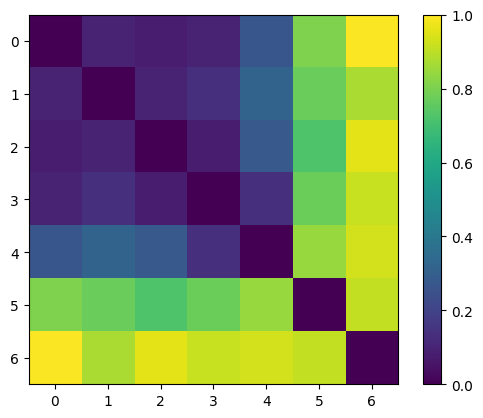

In [9]:
# plot correlation between predictors AL
corr_al = np.load("../results/rsa/preds_al_corr.npy")
plt.imshow(1-corr_al, cmap="viridis",vmin=0,vmax=1)
plt.colorbar()
plt.savefig(f"../results/plots/RSA_preds_corr-al-PCA_{pca}-{estimator}-{language}_{h}.png",dpi=300)

In [10]:
neural_vecs_al, neural_vecs_la = load_neural_rdms()

# Compute the upper noise ceiling
upper_nc_al = upper_noise_ceiling(neural_vecs_al)
# Compute the lower noise ceiling
lower_nc_al = lower_noise_ceiling(neural_vecs_al)

upper_nc_la = upper_noise_ceiling(neural_vecs_la)
lower_nc_la = lower_noise_ceiling(neural_vecs_la)

print("Lower Noise Ceiling AL:", lower_nc_al)
print("Upper Noise Ceiling AL:", upper_nc_al)
print("Lower Noise Ceiling LA:", lower_nc_la)
print("Upper Noise Ceiling LA:", upper_nc_la)


processing subject 1
processing subject 2
processing subject 3
processing subject 4
processing subject 5
processing subject 6
processing subject 7
processing subject 8
processing subject 9
processing subject 10
processing subject 11
processing subject 12
processing subject 13
processing subject 14
processing subject 15
processing subject 16
processing subject 17
processing subject 18
processing subject 19
processing subject 20
processing subject 21
processing subject 22
processing subject 23
processing subject 24
processing subject 25
Lower Noise Ceiling AL: 0.19084681010064258
Upper Noise Ceiling AL: 0.31271552293303634
Lower Noise Ceiling LA: 0.4718442784838331
Upper Noise Ceiling LA: 0.5254169947539415


# 2. Time averaged

In [11]:
# corr: correlation
# semi_all: semipartial correlation

# Parameters
corr_type = "corr"  # or "semi_all"
cluster = "base"
avg = True

# Load and prepare data
all_res, res_la, res_al, names = load_prep_corr_results(corr_type, cluster=cluster, avg=avg)

# Example: Display the first few rows
print(all_res.head())

          r  id coef_name type
0 -0.202648   1      SSIM   AL
1 -0.176963   1        V1   AL
2 -0.229102   1        V2   AL
3 -0.225030   1        V4   AL
4 -0.173375   1        IT   AL


In [12]:
bf_al = [pingouin.ttest(res_al[:,x], y=0, r=0.707, alternative='greater') for x in range(len(names))]
bf_la = [pingouin.ttest(res_la[:,x], y=0, r=0.707, alternative='greater') for x in range(len(names))]

pval_corrected_al = statsmodels.stats.multitest.multipletests([x['p-val'][0] for x in bf_al], alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)
pval_corrected_la = statsmodels.stats.multitest.multipletests([x['p-val'][0] for x in bf_la], alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)

# Print the corrected p-values with predictor names
print("Corrected p-values (AL):")
for name, pval in zip(names, pval_corrected_al[1]):
    print(f"{name}: {pval}")

print("\nCorrected p-values (LA):")
for name, pval in zip(names, pval_corrected_la[1]):
    print(f"{name}: {pval}")

t_al = [x['T'][0] for x in bf_al]
t_la = [x['T'][0] for x in bf_la]

# Extract Cohen's d values with predictor names
cohen_d_al = [x['cohen-d'][0] for x in bf_al]
cohen_d_la = [x['cohen-d'][0] for x in bf_la]

# Print Cohen's d and t values with predictor names
print("\nT and Cohen's d (AL):")
for name, t, d in zip(names, t_al, cohen_d_al):
    print(f"{name}: {t}, {d}")

print("\nT and Cohen's d (LA):")
for name, t, d in zip(names, t_la, cohen_d_la):
    print(f"{name}: {t}, {d}")

# Compute and print confidence intervals for Cohen's d values with predictor names
print("\nConfidence Intervals for Cohen's d (AL):")
for name, d in zip(names, cohen_d_al):
    ci_d_al = pingouin.compute_esci(d, nx=25, ny=0, paired=True, eftype='cohen', confidence=0.9, alternative='greater')
    print(f"{name}: {ci_d_al}")

print("\nConfidence Intervals for Cohen's d (LA):")
for name, d in zip(names, cohen_d_la):
    ci_d_la = pingouin.compute_esci(d, nx=25, ny=0, paired=True, eftype='cohen', confidence=0.9, alternative='greater')
    print(f"{name}: {ci_d_la}")

Corrected p-values (AL):
SSIM: 0.03126457797662763
V1: 0.0148137915055261
V2: 0.017029408124429806
V4: 0.03941978139367157
IT: 0.04886135690824879
semantic: 0.002466478873443781
actions: 0.0003915502707689215

Corrected p-values (LA):
SSIM: 0.009705981726350399
V1: 0.030483782628136225
V2: 1.0
V4: 1.0
IT: 1.6960593486507307e-09
semantic: 0.5128955280718619
actions: 0.25087240126095894

T and Cohen's d (AL):
SSIM: 2.8454059016615747, 0.5690811803323149
V1: 3.159803459479488, 0.6319606918958977
V2: 3.1018781597163283, 0.6203756319432656
V4: 2.745553224454652, 0.5491106448909304
IT: 2.6518800146029586, 0.5303760029205917
semantic: 3.8847383157662216, 0.7769476631532444
actions: 4.610284053808162, 0.9220568107616326

T and Cohen's d (LA):
SSIM: 3.3338012791921585, 0.6667602558384317
V1: 2.8562278445850287, 0.5712455689170057
V2: -8.053588626777545, 1.6107177253555087
V4: 0.9579301689813814, 0.19158603379627626
IT: 10.007307639901958, 2.001461527980392
semantic: 1.500442949626019, 0.3000885

## Plot

/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_12680/1853051837.py:38: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


([<matplotlib.axis.YTick at 0x140a57ac0>,
 [Text(0, -0.5, '−0.5'),
  Text(0, -0.4, '−0.4'),
  Text(0, -0.30000000000000004, '−0.3'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, -0.10000000000000009, '−0.1'),
  Text(0, -1.1102230246251565e-16, '0.0'),
  Text(0, 0.09999999999999987, '0.1'),
  Text(0, 0.19999999999999984, '0.2'),
  Text(0, 0.2999999999999998, '0.3'),
  Text(0, 0.3999999999999998, '0.4'),
  Text(0, 0.4999999999999998, '0.5'),
  Text(0, 0.5999999999999996, '0.6')])

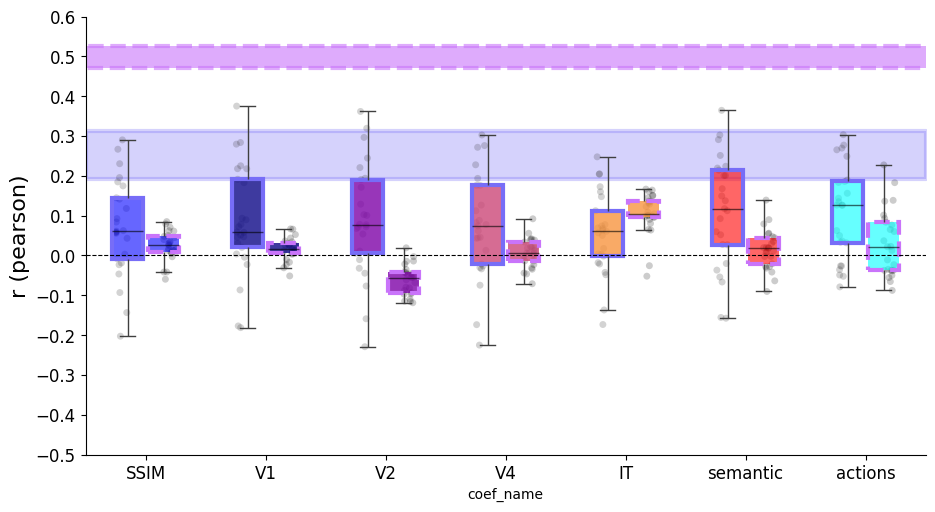

In [13]:
colors = rsa.create_cols_all(5,alpha=.8)[:4]

#[colors.append(x) for x in [(1, 0, 0, 0.6),(0, 1, 0, 0.6),(0, 1, 1, 0.6)]]
[colors.append(x) for x in [(1, 0, 0, 0.6),(0, 1, 1, 0.6)]]
colors.insert(0,(0,0,1,0.6))
if corr_type in ["semi","semi_all"]:    
    colors = colors[4:]
colors=colors*2

#5852B6
#776DF7
edgecols = list(np.repeat(["#776DF7","#C974FA"],len(names)))
linestyles = list(np.repeat(["-","--"],len(names)))

import seaborn as sns
if corr_type=="corr":
    fig, ax = plt.subplots(figsize = (14,6))
else:
    fig, ax = plt.subplots(figsize = (10,6))

ax = sns.boxplot(x="coef_name", y="r",
            hue="type", gap=.15,
            data=all_res, showfliers=False, notch=False,medianprops=dict(color="black", alpha=.6),legend=False,
            width=.6
            )
ax.fill_between(ax.get_xlim(), [upper_nc_al,upper_nc_al], [lower_nc_al,lower_nc_al], color="#776DF7", alpha=.3, linewidth=3)
ax.fill_between(ax.get_xlim(), [upper_nc_la,upper_nc_la], [lower_nc_la,lower_nc_la], color="#C974FA", alpha=.6,linewidth=3,linestyle="--")

for n in range(len(names)*2):
    patch=ax.patches[n]
    patch.set_facecolor(colors[n])
    patch.set_edgecolor(edgecols[n])
    patch.set_linewidth(3)
    patch.set_linestyle(linestyles[n])

rsa.add_boxplot_configs(ax,corr_type=corr_type)

sns.stripplot(
    data=all_res, x="coef_name", y="r", hue="type",
    dodge=True, alpha=.2, zorder=1, legend=False, color="black"
)
plt.ylabel("r (pearson)") if corr_type=="corr" else plt.ylabel("semi-partial r (pearson)")
plt.ylim(-.5,.6)#
plt.yticks(np.arange(-.5,.7,.1))
#plt.savefig(f"../results/plots/RSA_{corr_type}_{cluster}.png",dpi=300)

# 3. Plot full time-course

In [14]:
# corr: correlation
# semi_all: semipartial correlation
times = rsa.get_times("../"+config.eeg_data_dir)
cluster_times = rsa.load_cluster_times(prefix="../")

# Parameters
corr_type = "semi_all"  # or "semi_all"
cluster = "base"
avg = False

# Load and prepare data
all_res, res_la, res_al, names, timepoints = load_prep_corr_results(corr_type, cluster=cluster, avg=avg)

# Example: Display the first few rows
print(all_res.head())

          r  id coef_name type  time
0 -0.045819   1        IT   AL     0
1 -0.273773   1  semantic   AL     0
2 -0.029794   1   actions   AL     0
3 -0.032753   1        IT   LA     0
4 -0.005110   1  semantic   LA     0


## Plot

In [15]:
times[cluster_times[0]]

0.128

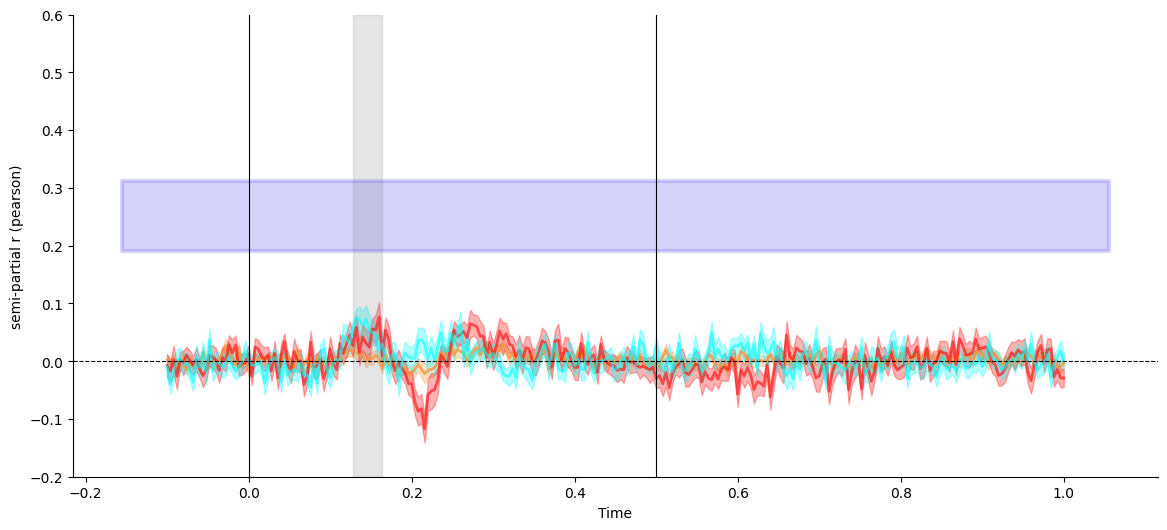

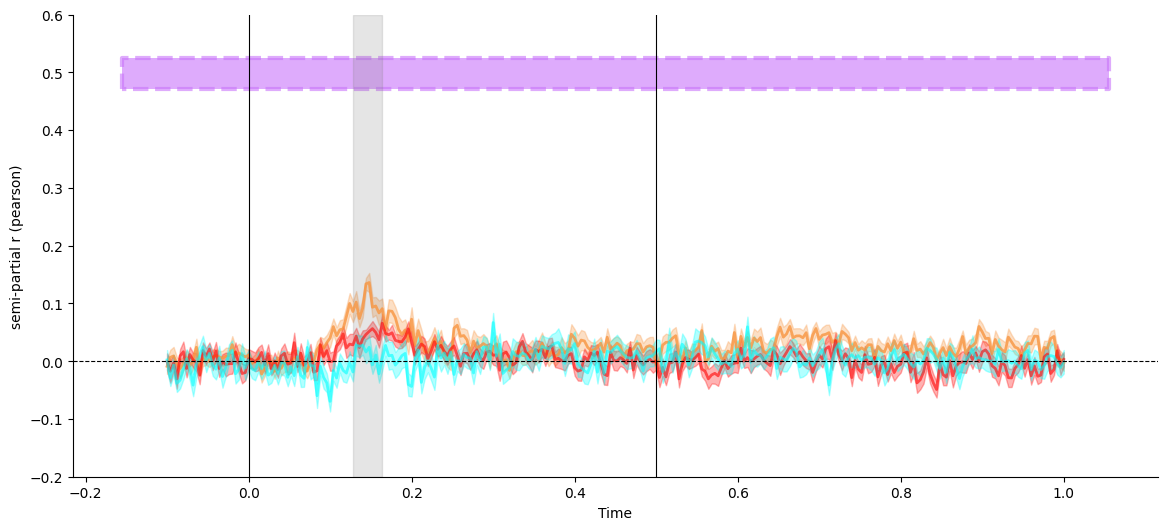

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `all_res` contains the time-resolved data
# Extracting unique timepoints for plotting
timepoints = all_res["time"].unique()

# Set up the colors and styles as before
colors = rsa.create_cols_all(5, alpha=.8)[:4]
[colors.append(x) for x in [(1, 0, 0, 0.6), (0, 1, 1, 0.6)]]
colors.insert(0, (0, 0, 1, 0.6))

if corr_type in ["semi", "semi_all"]:
    colors = colors[4:]
colors = colors * len(names)

edgecols = list(np.repeat(["#776DF7", "#C974FA"], len(names)))
linestyles = list(np.repeat(["-", "--"], len(names)))

# Plotting AL
fig_al, ax_al = plt.subplots(figsize=(14, 6))

for i, name in enumerate(names):
    subset = all_res[(all_res["coef_name"] == name) & (all_res["type"] == "AL")]
    mean_r = subset.groupby("time")["r"].mean()
    sem_r = subset.groupby("time")["r"].sem()
    
    ax_al.plot(times, mean_r, color=colors[i], linestyle=linestyles[i], linewidth=2, label=name)
    ax_al.fill_between(times, mean_r - sem_r, mean_r + sem_r, color=colors[i], alpha=0.3)

# Adding noise ceilings
ax_al.fill_between(ax_al.get_xlim(), [upper_nc_al, upper_nc_al], [lower_nc_al, lower_nc_al], color="#776DF7", alpha=.3, linewidth=3)
# vertical grey bar for cluster times
ax_al.axvspan(times[cluster_times[0]], times[cluster_times[-1]], color="grey", alpha=0.2)

# Configure AL plot aesthetics
ax_al.set_xlabel("Time")
ax_al.set_ylabel("r (pearson)" if corr_type == "corr" else "semi-partial r (pearson)")
ax_al.set_ylim(-0.2, 0.6)
ax_al.set_yticks(np.arange(-0.2, 0.7, 0.1))
ax_al.axhline(0, color='k', linestyle='--', label='chance', linewidth=.8)
ax_al.axvline(.0, color='k', linestyle='-', linewidth=.8)
ax_al.axvline(.5, color='k', linestyle='-', linewidth=.8)
ax_al.spines['top'].set_visible(False)
ax_al.spines['right'].set_visible(False)

# Optionally, save the AL plot
plt.savefig(f"../results/plots/RSA_{corr_type}_{cluster}_AL_timecourse.png", dpi=300)

# Plotting LA
fig_la, ax_la = plt.subplots(figsize=(14, 6))

for i, name in enumerate(names):
    subset = all_res[(all_res["coef_name"] == name) & (all_res["type"] == "LA")]
    mean_r = subset.groupby("time")["r"].mean()
    sem_r = subset.groupby("time")["r"].sem()
    
    ax_la.plot(times, mean_r, color=colors[i], linestyle=linestyles[i], linewidth=2, label=name)
    ax_la.fill_between(times, mean_r - sem_r, mean_r + sem_r, color=colors[i], alpha=0.3)

# Adding noise ceilings
ax_la.fill_between(ax_la.get_xlim(), [upper_nc_la, upper_nc_la], [lower_nc_la, lower_nc_la], color="#C974FA", alpha=.6, linewidth=3, linestyle="--")
# vertical grey bar for cluster times
ax_la.axvspan(times[cluster_times[0]], times[cluster_times[-1]], color="grey", alpha=0.2)

# Configure LA plot aesthetics
ax_la.set_xlabel("Time")
ax_la.set_ylabel("r (pearson)" if corr_type == "corr" else "semi-partial r (pearson)")
ax_la.set_ylim(-0.2, 0.6)
ax_la.set_yticks(np.arange(-0.2, 0.7, 0.1))
ax_la.axhline(0, color='k', linestyle='--', label='chance', linewidth=.8)
ax_la.axvline(.0, color='k', linestyle='-', linewidth=.8)
ax_la.axvline(.5, color='k', linestyle='-', linewidth=.8)
ax_la.spines['top'].set_visible(False)
ax_la.spines['right'].set_visible(False)

# Optionally, save the LA plot
plt.savefig(f"../results/plots/RSA_{corr_type}_{cluster}_LA_timecourse.png", dpi=300)

plt.show()
